# Предсказание риска сердечных приступов

Ссылка на проект в GitHub - https://github.com/MaratKadyrov/heart_attack

**Цель исследования:**
- Создать модель для предсказания риска сердечных приступов

**Ход исследования:**
- Импорт данных;
- Предобработка данных;
- Исследование датасета;
- Обучение модели.

**Описание признаков**
| Признак | Описание |
|:--:|:--:|
| **Age** | Возраст (количественный, отмасштабирован) |
| **Cholesterol** | Холестерин в крови (количественный, отмасштабирован) |
| **Heart rate** | Частота сердечных сокращений (количественный, отмасштабирован) |
| **Diabetes** | Наличие диабета (категориальный) |
| **Family History** | История семьи (категориальный) |
| **Smoking** | Курит ли пациент (категориальный) |
| **Obesity** | Ожирение (категориальный) |
| **Alcohol Consumption** | Употребляет ли пациент алкоголь (категориальный) |
| **Exercise Hours Per Week** | Физическая активность, часов в неделю (количественный, отмасштабирован) |
| **Diet** | Диета (категориальный) |
| **Previous Heart Problems** | Наличие проблем с сердец в прошлом (категориальный) |
| **Medication Use** | Использует ли пациент лекарства (категориальный) |
| **Stress Level** | Уровень стресса (количественный дискретный) |
| **Sedentary Hours Per Day** | Количество часов в сидячем положении (количественный, отмасштабирован) |
| **Income** | Доход (количественный, отмасштабирован) |
| **BMI** | Индекс массы тела (количественный, отмасштабирован) |
| **Triglycerides** | Триглицериды (количественный, отмасштабирован) | 
| **Physical Activity Days Per Week** | Количество дней активности в неделю (количественный дискретный) |
| **Sleep Hours Per Day** | Количество часов сна в день (количественный дискретный) |
| **Heart Attack Risk (Binary)** | Риск сердечного приступа (категориальный, **целевой признак**) |
| **Blood sugar** | Сахар в крови (количественный, отмасштабирован) | 
| **CK-MB** | Креатинкиназа МВ (количественный, отмасштабирован) | 
| **Troponin** | Тропонин (количественный, отмасштабирован) | 
| **Gender** | Пол (категориальный) |
| **Systolic blood pressure** | Систолическое артериальное давление (количественный, отмасштабирован) |
| **Diastolic blood pressure** | Диастолическое артериальное давление (количественный, отмасштабирован) |
| **id** | Уникальный идентификатор пациента |

## Импорт библиотек

In [499]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   LabelEncoder)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

from optuna import distributions
from optuna.integration import OptunaSearchCV

from warnings import simplefilter
simplefilter(action='ignore')

pd.set_option('display.float_format', '{:,.2f}'.format)
RANDOM_STATE = 42

## Загрузка данных

In [398]:
pth_train = 'heart_train.csv'
pth_test = 'heart_test.csv'

In [399]:
if os.path.exists(pth_train):
    train_df = pd.read_csv(pth_train)
else:
    print('Упс, что-то пошло не так!')
                                         
train_df.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.36,0.73,0.07,1.00,1.00,1.00,1.00,1.00,0.54,...,3.00,0.33,0.00,0.23,0.05,0.04,Male,0.21,0.71,2664
1,1,0.20,0.33,0.05,1.00,1.00,0.00,0.00,1.00,0.07,...,3.00,0.83,0.00,0.15,0.02,0.00,Female,0.41,0.57,9287
2,2,0.61,0.86,0.06,1.00,0.00,1.00,1.00,1.00,0.94,...,2.00,1.00,0.00,0.23,0.05,0.04,Female,0.24,0.22,5379
3,3,0.73,0.01,0.05,0.00,0.00,1.00,0.00,1.00,0.70,...,0.00,0.33,1.00,0.23,0.05,0.04,Female,0.35,0.27,8222
4,4,0.78,0.76,0.02,0.00,0.00,1.00,0.00,1.00,0.41,...,5.00,1.00,1.00,0.23,0.05,0.04,Male,0.62,0.44,4047


In [400]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [401]:
if os.path.exists(pth1):
    test_df = pd.read_csv(pth_test)
else:
    print('Упс, что-то пошло не так!')
                                         
train_df.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.36,0.73,0.07,1.00,1.00,1.00,1.00,1.00,0.54,...,3.00,0.33,0.00,0.23,0.05,0.04,Male,0.21,0.71,2664
1,1,0.20,0.33,0.05,1.00,1.00,0.00,0.00,1.00,0.07,...,3.00,0.83,0.00,0.15,0.02,0.00,Female,0.41,0.57,9287
2,2,0.61,0.86,0.06,1.00,0.00,1.00,1.00,1.00,0.94,...,2.00,1.00,0.00,0.23,0.05,0.04,Female,0.24,0.22,5379
3,3,0.73,0.01,0.05,0.00,0.00,1.00,0.00,1.00,0.70,...,0.00,0.33,1.00,0.23,0.05,0.04,Female,0.35,0.27,8222
4,4,0.78,0.76,0.02,0.00,0.00,1.00,0.00,1.00,0.41,...,5.00,1.00,1.00,0.23,0.05,0.04,Male,0.62,0.44,4047


In [402]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

In [403]:
# Составим списки для количественных и категориальных признаков
numerical_features = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Stress Level', # дискретный
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Physical Activity Days Per Week',  # дискретный
    'Sleep Hours Per Day',  # дискретный
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure'
]

categorical_features = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use',
    'Heart Attack Risk (Binary)',
    'Gender'
]

Вывод
- В датафрейме 8685 строк;
- Есть пропуски;

## Предобработка данных

### Удаление признака "Unnamed: 0"

In [404]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

print(train_df.columns)
print(test_df.columns)

Index(['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day',
       'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin',
       'Gender', 'Systolic blood pressure', 'Diastolic blood pressure', 'id'],
      dtype='object')
Index(['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Blood sugar',
       'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure',
       'Diastolic blood 

### Обработка дубликатов

#### Проверка явных дубликатов

In [405]:
train_df.duplicated().sum()

0

#### Проверка неявных дубликатов

In [406]:
# Поиск дубликатов по ID
train_df['id'].duplicated().sum()

0

In [407]:
# Поиск дубликатов по всем признакам, за исключение признака ID
train_df.drop('id', axis=1).duplicated().sum()

0

### Обработка пропусков

In [408]:
missing_values = train_df.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Physical Activity Days Per Week    243
dtype: int64

### Обработка выбросов

In [409]:
def statistics_for_num(feature):
    # Расчет количество выбросов
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    
    print(f"Признак - {feature}")
    print(f"Количество выбросов: {len(outliers)}")
    print()

In [410]:
for feature in numerical_features:
    statistics_for_num(feature)

Признак - Age
Количество выбросов: 0

Признак - Cholesterol
Количество выбросов: 0

Признак - Heart rate
Количество выбросов: 2

Признак - Exercise Hours Per Week
Количество выбросов: 0

Признак - Stress Level
Количество выбросов: 0

Признак - Sedentary Hours Per Day
Количество выбросов: 0

Признак - Income
Количество выбросов: 0

Признак - BMI
Количество выбросов: 0

Признак - Triglycerides
Количество выбросов: 0

Признак - Physical Activity Days Per Week
Количество выбросов: 0

Признак - Sleep Hours Per Day
Количество выбросов: 0

Признак - Blood sugar
Количество выбросов: 2134

Признак - CK-MB
Количество выбросов: 2134

Признак - Troponin
Количество выбросов: 2134

Признак - Systolic blood pressure
Количество выбросов: 0

Признак - Diastolic blood pressure
Количество выбросов: 0



In [411]:
# Выявим выбросы в признаке 'Heart rate'
train_df[train_df['Heart rate'] == 1]

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
1377,0.63,0.50,1.00,NaN,NaN,NaN,NaN,NaN,0.50,3,...,NaN,0.50,0.00,0.20,0.01,0.00,0.0,0.49,0.62,9547
2712,0.20,0.50,1.00,NaN,NaN,NaN,NaN,NaN,0.50,3,...,NaN,0.50,0.00,0.09,0.01,0.00,0.0,0.49,0.62,9611


In [412]:
# Удалим выбросы в признаке 'Heart rate'
train_df = train_df[train_df['Heart rate'] != 1]

In [413]:
statistics_for_num('Heart rate')

Признак - Heart rate
Количество выбросов: 0



Вывод по подразделу "Обработка выбросов":
- Выполнено удаление выбросов признаке **"Heart rate"**
- Для остальных признаков, количество выбросов составляет значительную часть датасеты, и их удаление невозможно.

### Аномалии в признаке "Gender"

In [414]:
# Отобразим количество по категориям
train_df['Gender'].value_counts()

Gender
Male      5882
Female    2560
1.0        156
0.0         85
Name: count, dtype: int64

In [415]:
test_df['Gender'].value_counts()

Gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64

Вывод по подразделу 'Аномалии в признаке "Gender"':
- Часть данных закодирована
- Аналогичная проблема присутсвует в тестовом датасете
- Эта проблема будет исправлена в пайплайне

Вывод по разделу **"Предобработка данных"**:
- Удален признак **"Unnamed: 0"** как неинформативный;
- Дубликаты отсутствуют;
- Выполнено удаление выбросов признаке **"Heart rate"**;
- Часть данных в признаке **"Gender"** закодирована. Аналогичная проблема присутсвует в тестовом датасете. Эта проблема будет исправлена в пайплайне

## Исследовательский анализ

In [416]:
def visualize_categorical_feature(df, plot=None, feature = None, hue = None, title = None, xlabel = None, ylabel = None):
    """
    Визуализирует и анализирует категориальные признаки.
    
    :param df: DataFrame с данными
    :param feature: категориальных признак для анализа
    """
    counts = df[feature].value_counts()

    # График распределения
    plt.figure(figsize=(6, 6))
    
    if plot == None:
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140);
    else:
        sns.countplot(data=df,
                      x=feature,
                      hue=hue,
                      palette="summer",
                     order=df[feature].value_counts().index);
        if xlabel: plt.xlabel(xlabel)
        if ylabel: plt.ylabel(ylabel)
    if title:
        plt.title(f'{title}')
    else:
        plt.title(f'{feature}')
    plt.show()

    # Статистика
    print(f'Статистика для {feature}:')
    print(f'- Уникальные значения: {df[feature].nunique()}')
    print()
    print(f'- Мода: {df[feature].mode()[0]}')
    print()
    if hue == None:
        print(f'- Частота по категориям:\n{df[feature].value_counts()}')
        print()
        print(f'- Процентное соотношение:\n{df[feature].value_counts(normalize=True).round(2) * 100}')
    else:
        pivot_table = df.pivot_table(index=feature,
                              columns=hue,
                              values='id',
                              aggfunc='count',
                              fill_value=0)

        # Расчет пропорций
        pivot_table_proportion = pivot_table.div(len(df))

        # Объединение данных
        final_table = pd.concat([pivot_table, pivot_table_proportion], axis=1, keys=['Count', 'Proportion'])
        return final_table

In [417]:
def visualize_numerical_feature(df, feature = None, xlabel = None, title = None, bins = 30, hue=None):
    """
    Создает комбинированный график, состоящий из 
    - боксплотта и гистограммы для количественного признака
    - countplot для дискретного признака.

    Параметры:
    - df: DataFrame, содержащий данные для визуализации.
    - feature: str, название признака для построения графиков.
    - xlabel: str, метка для оси X (по умолчанию None).
    - bins: int, количество корзин для гистограммы (по умолчанию 50).
    - hue: str, bool, добавляет в график разбиение по признаку(str=feature) или всем категориальным признакам (hue=True), 
    количество уникальных значений не более 5

    Возвращаемое значение: Отображает статистические данные и выводит графики на экран.
    """
    
    # Сформируем список категориальных признаков, 
    # где количество уникальных значений меньше лиибо равно 5 (чтобы не перегружать график)
    cat_features = [feat for feat in df.columns if df[feat].dtype == 'object' and df[feat].nunique() <=6]

    # Статистические данные
    uniq = df[feature].nunique()
    mean = df[feature].mean()
    median = df[feature].median()
    std = df[feature].std()
    min_val = df[feature].min()
    max_val = df[feature].max()
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    print(f"Статистики для {feature}:")
    print(f"Уникальных значений: {uniq:.0f}")
    print(f"Среднее: {mean:.2f}")
    print(f"Медиана: {median:.2f}")
    print(f"Стандартное отклонение: {std:.2f}")
    print(f"Минимум: {min_val:.2f}")
    print(f"Максимум: {max_val:.2f}")
    
    # Визуализация
    sns.set(font_scale=1)
    
    # График для дискретных значений
    if uniq <= 20:
        if hue == None or isinstance(hue, str):
            plt.figure(figsize = (10, 5))
            sns.countplot(data=df, 
                         x=feature,
                         color='skyblue', 
                         edgecolor='black',
                         hue=hue)
            plt.axvline(x=mean-min_val, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median-min_val, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if title: plt.title(title)
            if xlabel: plt.xlabel(xlabel)
            plt.show()

            '''
            # Графики с разделением по категориальным признакам
            fig, axes = plt.subplots(nrows=len(cat_features),
                                     ncols= 1,
                                     figsize=(14, 18))
            axes =axes.flatten()
            
            for index, feat in enumerate(cat_features):
                handles = []
                labels = []
                ax = axes[index]

                hist = sns.countplot(data=df, 
                             x=feature, 
                             color='skyblue', 
                             edgecolor='black',
                             hue=feat,
                             ax=ax)


                for cat in df[feat].unique():
                    mean_value = df[df[feat] == cat][feature].mean()
                    line_handle = ax.axvline(x=mean_value-min_val, 
                                             color=f'#{random.randint(0, 0xFFFFFF):06x}',
                                             ls='--', 
                                             lw=2)
                    handles.append(line_handle)
                    labels.append(f'Mean {feat}={cat}')

                ax.set_title(f'{title} по признаку {feat}')
                if xlabel: ax.set_xlabel(xlabel)

                ax.legend(handles, labels)

            plt.tight_layout()
'''
            
            plt.show()
            
    # График для количественных признаков
    else:
        print(f"Q1: {q1:.2f}")
        print(f"Q3: {q3:.2f}")
        print(f"Количество выбросов: {len(outliers)}")
        if hue == None or isinstance(hue, str):
            f2, (ax_box2, ax_hist2) = plt.subplots(2, 
                                                   sharex=True, 
                                                   gridspec_kw={"height_ratios": (.15, .85)}, 
                                                   figsize=(12,6))
            sns.boxplot(data=df,
                        x=feature,
                        color='skyblue',
                        ax=ax_box2)
            sns.histplot(data=df, 
                         x=feature,
                         ax=ax_hist2, 
                         color='skyblue', 
                         edgecolor='black',
                         bins=bins,
                         hue=hue,
                         multiple='stack',
                         legend=True,
                         kde=True)
            plt.axvline(x=mean, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if xlabel: ax_hist2.set(xlabel=xlabel)
            if title: ax_box2.set(title=title)
            plt.show()

        elif hue:
            # Основной график
            f2, (ax_box2, ax_hist2) = plt.subplots(2, 
                                                   sharex=True, 
                                                   gridspec_kw={"height_ratios": (.15, .85)}, 
                                                   figsize=(14, 6))

            sns.boxplot(data=df,
                    x=feature,
                    color='skyblue',
                    ax=ax_box2)
            viz_box_plot = False
            sns.histplot(data=df, 
                     x=feature,
                     ax=ax_hist2, 
                     color='skyblue', 
                     edgecolor='black',
                     bins=bins,
                     multiple='stack',
                     legend=True,
                     kde=True)
            plt.axvline(x=mean, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if xlabel: ax_hist2.set(xlabel=xlabel)
            if title: ax_box2.set(title=title)

            # Графики с разделением по категориальным признакам
            fig, axes = plt.subplots(nrows=len(cat_features),
                                     ncols= 1,
                                     figsize=(12, 18))
            axes = axes.flatten()

            for index, feat in enumerate(cat_features):
                handles = []
                labels = []
                ax = axes[index]

                hist = sns.histplot(data=df,
                                    x=feature,
                                    color='skyblue', 
                                    edgecolor='black',
                                    bins=bins,
                                    hue=feat,
                                    stat='density', 
                                    common_norm=False,
                                    multiple='stack',
                                    legend=True,
                                    ax=ax)


                for cat in df[feat].unique():
                    mean_value = df[df[feat] == cat][feature].mean()
                    line_handle = ax.axvline(x=mean_value, 
                                             color=f'#{random.randint(0, 0xFFFFFF):06x}',
                                             ls='--', 
                                             lw=2)
                    handles.append(line_handle)
                    labels.append(f'Mean {feat}={cat}')

                ax.set_title(f'{title} по признаку {feat}')
                if xlabel: ax.set_xlabel(xlabel)

                ax.legend(handles, labels)

            plt.tight_layout()
            plt.show()

In [418]:
def proportion_table(df, feature, hue):
    pivot_table = df.pivot_table(index=feature,
                                  columns=hue,
                                  values='id',
                                  aggfunc='count',
                                  fill_value=0)

    # Расчет пропорций
    pivot_table_proportion = pivot_table.div(len(df))

    # Обхединение данных
    final_table = pd.concat([pivot_table, pivot_table_proportion], axis=1, keys=['Count', 'Proportion'])
    return final_table

#### Количественный признак "Age"

Статистики для Age:
Уникальных значений: 77
Среднее: 0.45
Медиана: 0.46
Стандартное отклонение: 0.23
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.64
Количество выбросов: 0


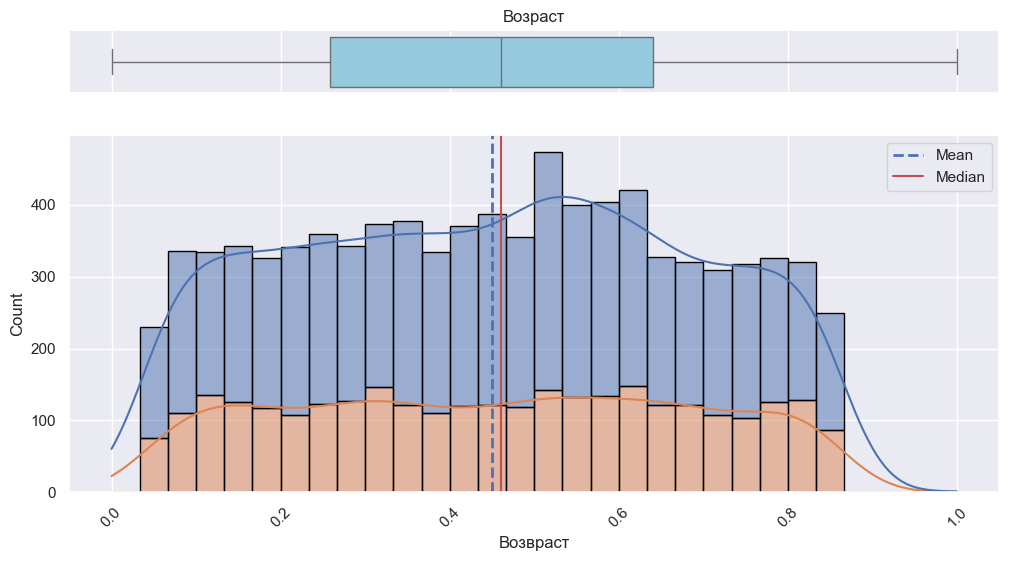

In [419]:
visualize_numerical_feature(df=train_df, 
                            feature='Age', 
                            bins = 30, 
                            title='Возраст', 
                            xlabel='Возвраст',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Age"**:
- Данные содержат возвраст;
- Данные отмасштабированны;
- Частота сердечных приступов, для всех возврастов, примерно одинакова.

#### Количественный признак "Cholesterol"

Статистики для Cholesterol:
Уникальных значений: 282
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.27
Q3: 0.75
Количество выбросов: 0


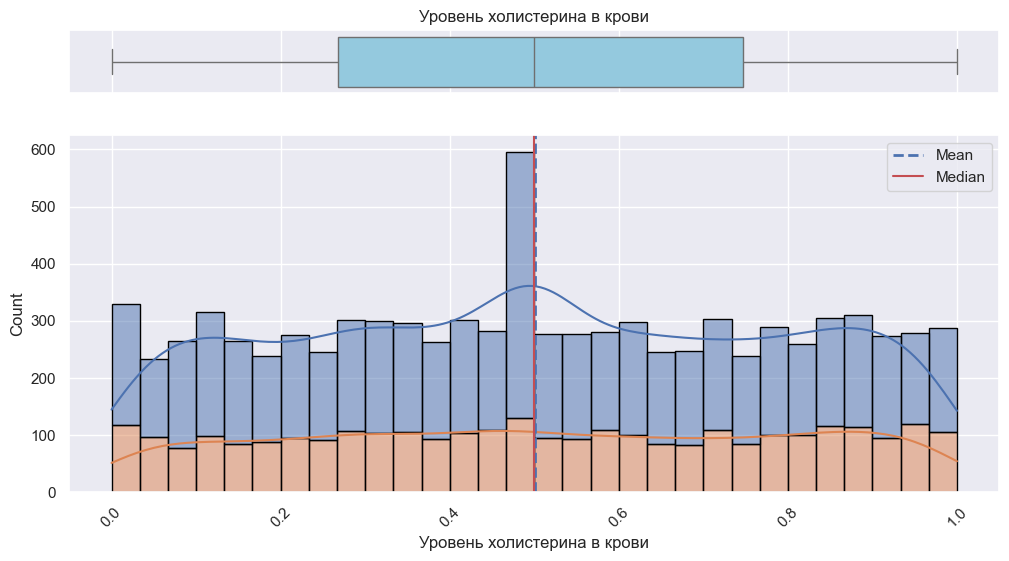

In [420]:
visualize_numerical_feature(df=train_df, 
                            feature='Cholesterol', 
                            bins = 30, 
                            title='Уровень холистерина в крови', 
                            xlabel='Уровень холистерина в крови',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Cholesterol"**:
- Данные уровень холистерина в крови;
- Данные отмасштабированны;
- Частота сердечных приступов, для всех значений холистерина, примерно одинакова.

#### Количественный признак "Heart rate"

Статистики для Heart rate:
Уникальных значений: 86
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.02
Минимум: 0.00
Максимум: 0.11
Q1: 0.03
Q3: 0.07
Количество выбросов: 0


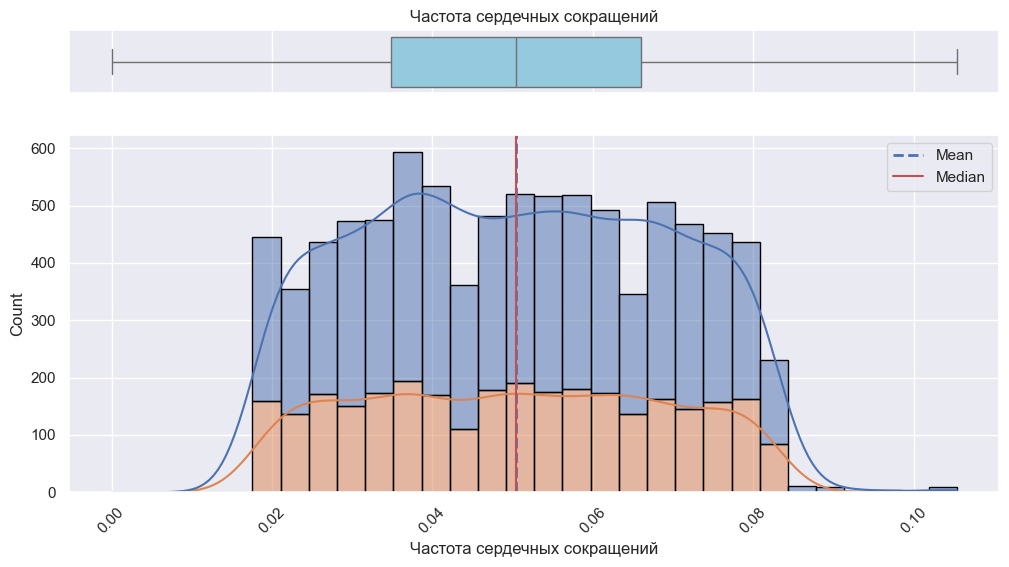

In [421]:
visualize_numerical_feature(df=train_df, 
                            feature='Heart rate', 
                            bins = 30, 
                            title='Частота сердечных сокращений', 
                            xlabel='Частота сердечных сокращений',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Heart rate"**:
- Данные отмасштабированны;
- Частота сердечных приступов, для всех значений частоты сердечных сокращений, примерно одинакова.

#### Количественный признак "Exercise Hours Per Week"

Статистики для Exercise Hours Per Week:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.75
Количество выбросов: 0


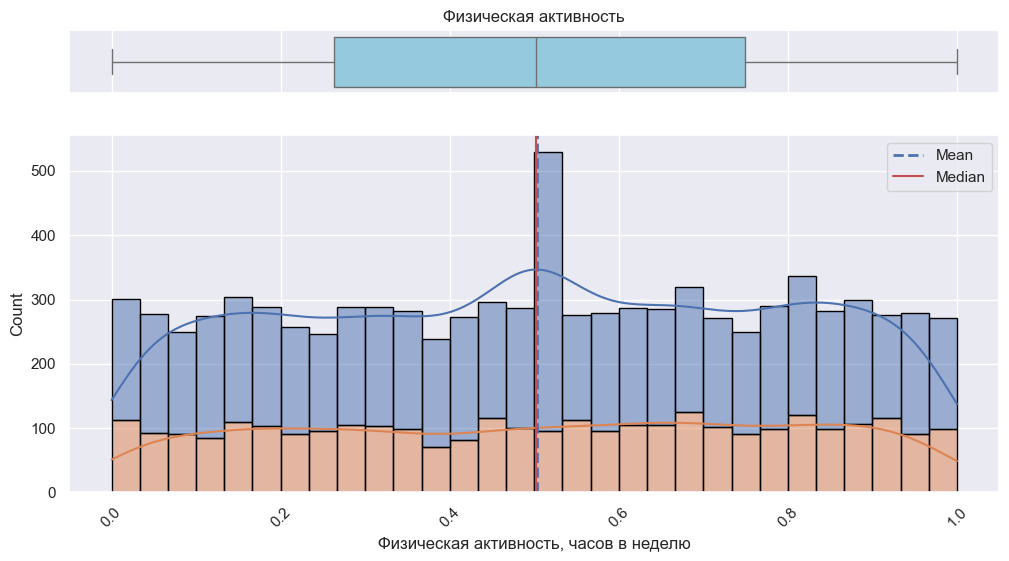

In [422]:
visualize_numerical_feature(df=train_df, 
                            feature='Exercise Hours Per Week', 
                            bins = 30, 
                            title='Физическая активность', 
                            xlabel='Физическая активность, часов в неделю',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Exercise Hours Per Week"**:
- Данные отмасштабированны;
- Для медианного значения физической активности, имеется пик отсутствия сердечных приступов.

#### Дискретный признак "Stress Level"

Статистики для Stress Level:
Уникальных значений: 10
Среднее: 5.49
Медиана: 5.00
Стандартное отклонение: 2.87
Минимум: 1.00
Максимум: 10.00


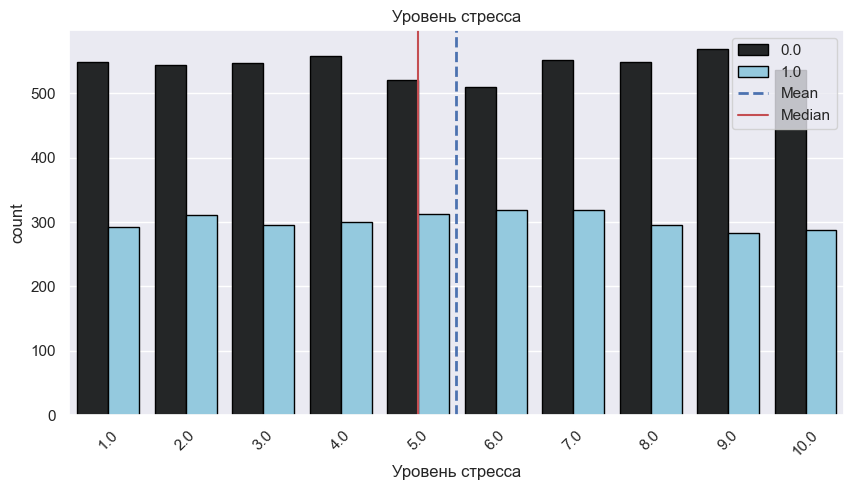

In [423]:
visualize_numerical_feature(df=train_df, 
                            feature='Stress Level',
                            title='Уровень стресса', 
                            xlabel='Уровень стресса',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Stress Level"**:
- Для медианного значения уровня стресса = 5, наблюдается пик отсутствия сердечных приступов.

#### Количественный признак "Sedentary Hours Per Day"

Статистики для Sedentary Hours Per Day:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.29
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.74
Количество выбросов: 0


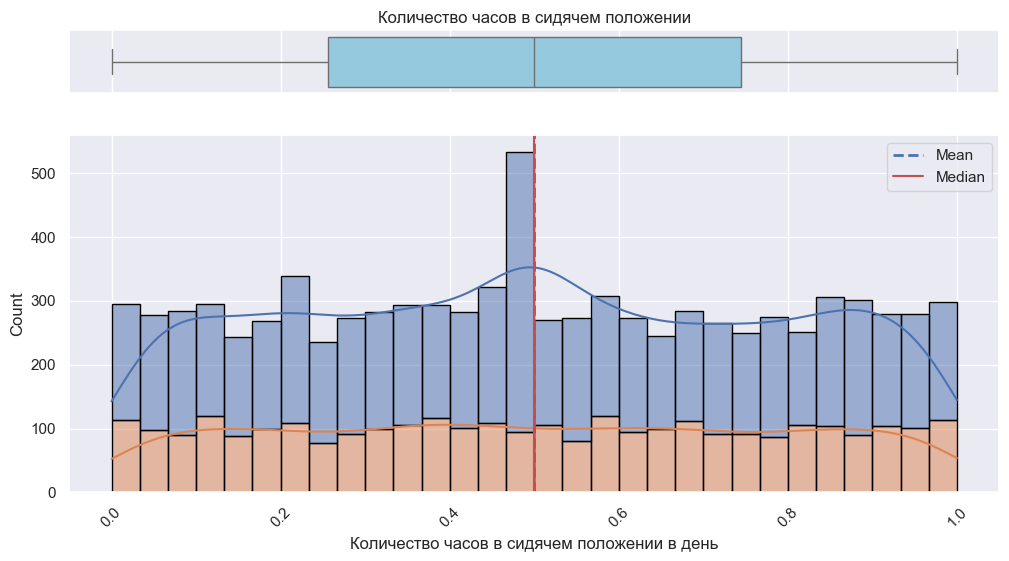

In [424]:
visualize_numerical_feature(df=train_df, 
                            feature='Sedentary Hours Per Day', 
                            bins = 30, 
                            title='Количество часов в сидячем положении', 
                            xlabel='Количество часов в сидячем положении в день',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Sedentary Hours Per Day"**:
- Данные отмасштабированны;
- Для медианного значения количества часов в сидячем положении = 0,5, наблюдается пик отсутствия сердечных приступов.

#### Количественный признак "Income"

Статистики для Income:
Уникальных значений: 7808
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.25
Q3: 0.74
Количество выбросов: 0


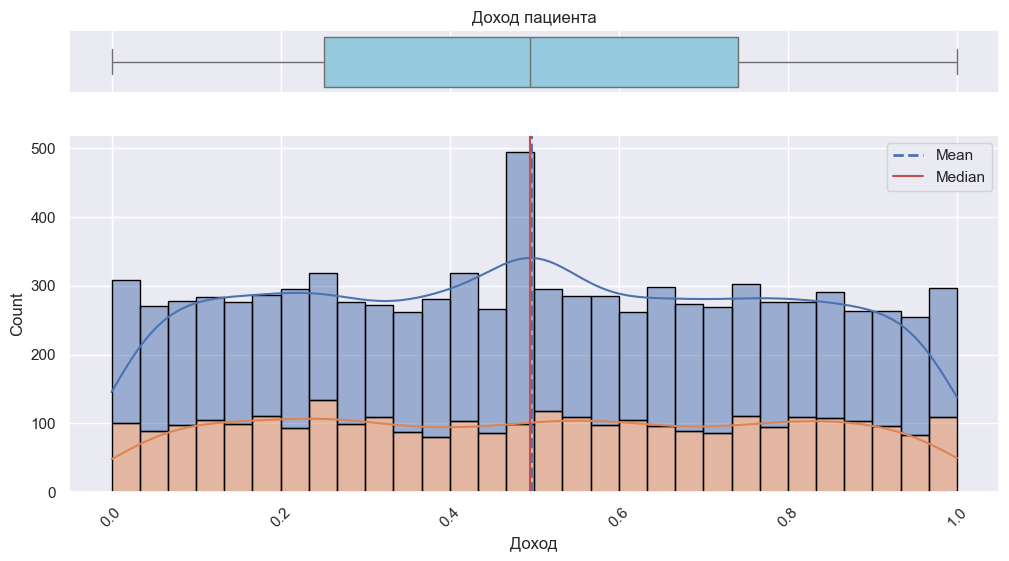

In [425]:
visualize_numerical_feature(df=train_df, 
                            feature='Income', 
                            bins = 30, 
                            title='Доход пациента', 
                            xlabel='Доход',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Income"**:
- Данные отмасштабированны;
- Для медианного значения дохода, наблюдается пик отсутствия сердечных приступов.

#### Количественный признак "BMI"

Статистики для BMI:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.25
Q3: 0.74
Количество выбросов: 0


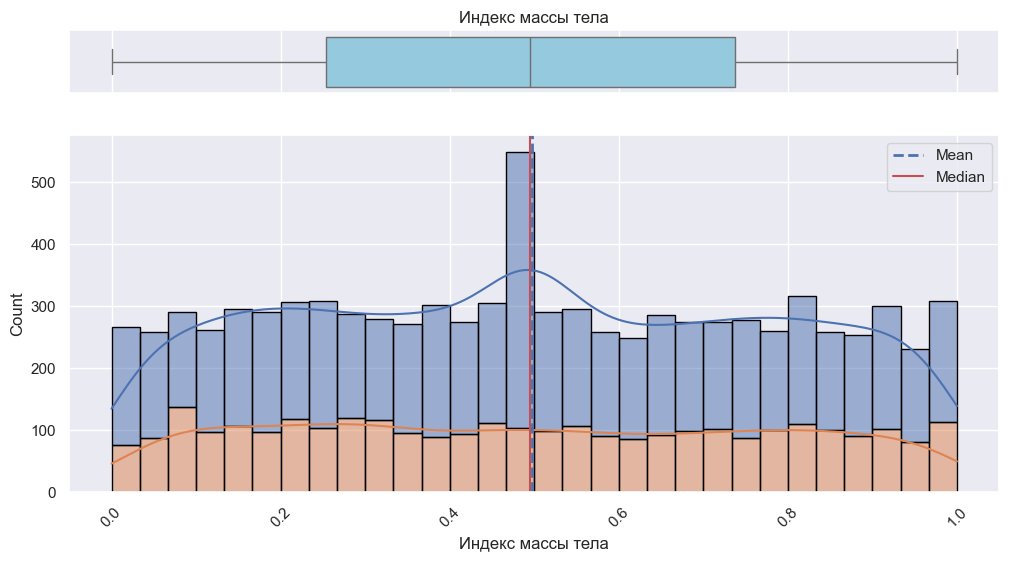

In [426]:
visualize_numerical_feature(df=train_df, 
                            feature='BMI', 
                            bins = 30, 
                            title='Индекс массы тела', 
                            xlabel='Индекс массы тела',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "BMI"**:
- Данные отмасштабированны;
- Для медианного значения индекса массы тела, наблюдается пик отсутствия сердечных приступов.

#### Количественный признак "Triglycerides"

Статистики для Triglycerides:
Уникальных значений: 772
Среднее: 0.51
Медиана: 0.50
Стандартное отклонение: 0.29
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.75
Количество выбросов: 0


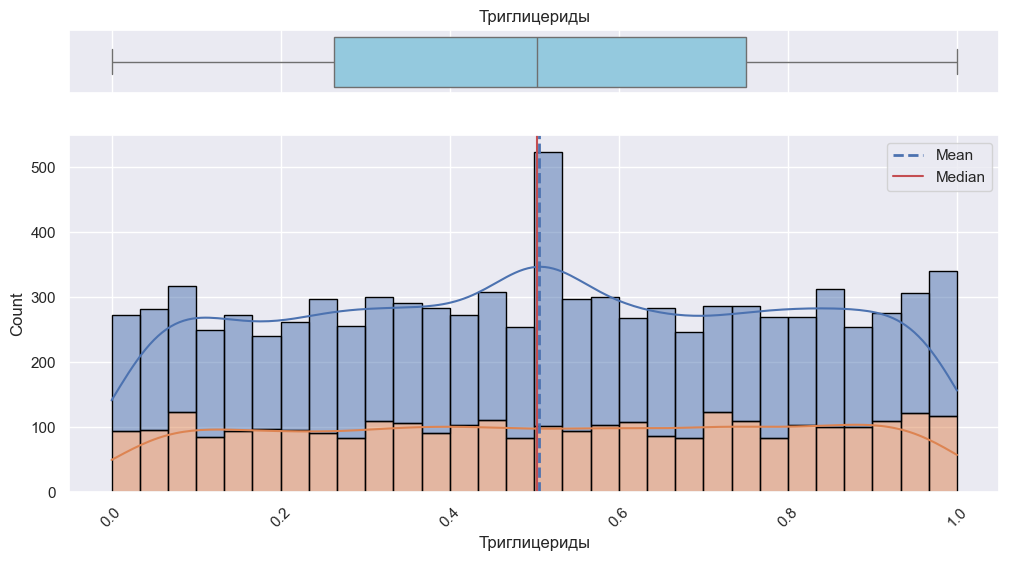

In [427]:
visualize_numerical_feature(df=train_df, 
                            feature='Triglycerides', 
                            bins = 30, 
                            title='Триглицериды', 
                            xlabel='Триглицериды',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Triglycerides"**:
- Данные отмасштабированны;
- Для медианного значения триглицеридов, наблюдается пик отсутствия сердечных приступов.

#### Дискретный признак "Physical Activity Days Per Week"

Статистики для Physical Activity Days Per Week:
Уникальных значений: 8
Среднее: 3.51
Медиана: 3.00
Стандартное отклонение: 2.28
Минимум: 0.00
Максимум: 7.00


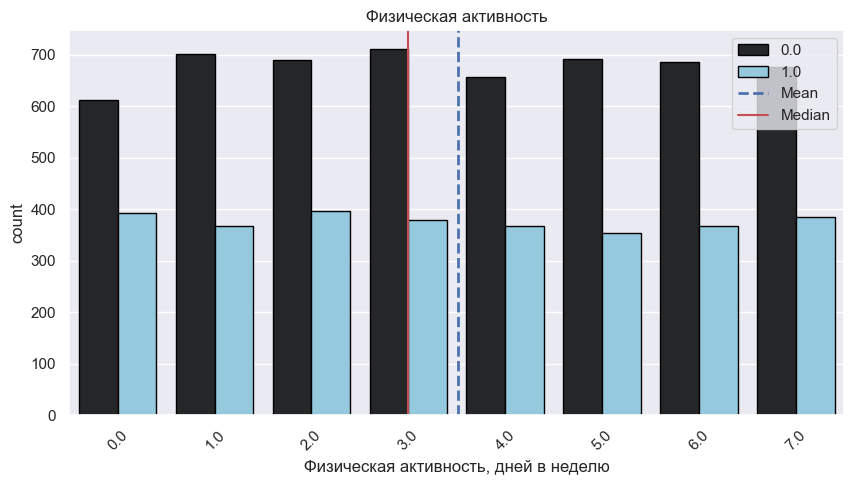

In [428]:
visualize_numerical_feature(df=train_df, 
                            feature='Physical Activity Days Per Week',
                            title='Физическая активность', 
                            xlabel='Физическая активность, дней в неделю',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Physical Activity Days Per Week"**:
- Для медианного значения физической активности = 3, наблюдается пик отсутствия сердечных приступов.

#### Дискретный признак "Sleep Hours Per Day"

Статистики для Sleep Hours Per Day:
Уникальных значений: 8
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.33
Минимум: 0.00
Максимум: 1.00


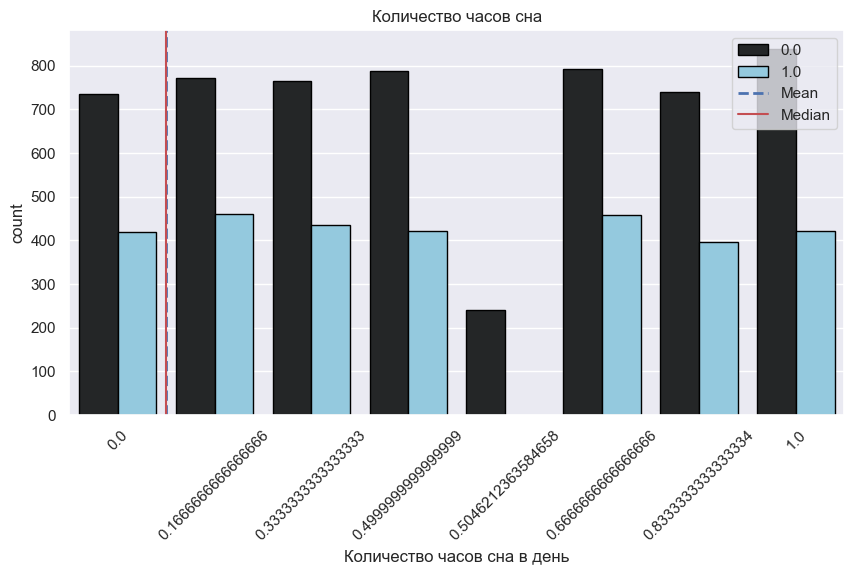

In [429]:
visualize_numerical_feature(df=train_df, 
                            feature='Sleep Hours Per Day',
                            title='Количество часов сна', 
                            xlabel='Количество часов сна в день',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Sleep Hours Per Day"**:
- Данные отмасштабированны;
- отсутсвуют данные по риску сердечного приступа для 0,5 часов сна

#### Количественный признак "Blood sugar"

Статистики для Blood sugar:
Уникальных значений: 239
Среднее: 0.23
Медиана: 0.23
Стандартное отклонение: 0.08
Минимум: 0.00
Максимум: 1.00
Q1: 0.23
Q3: 0.23
Количество выбросов: 2132


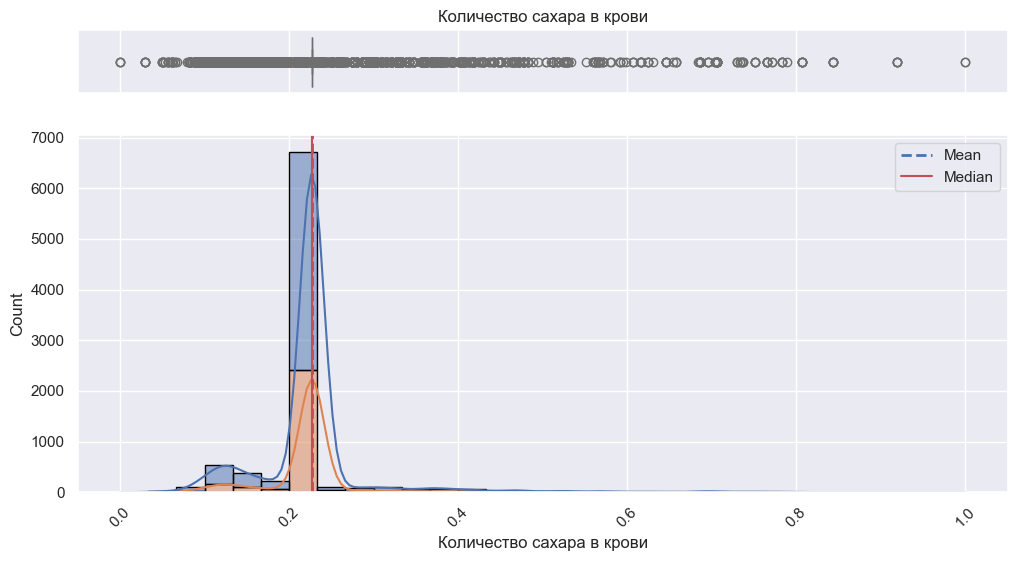

In [430]:
visualize_numerical_feature(df=train_df, 
                            feature='Blood sugar', 
                            bins = 30, 
                            title='Количество сахара в крови', 
                            xlabel='Количество сахара в крови',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Blood sugar"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "CK-MB"

Статистики для CK-MB:
Уникальных значений: 678
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.08
Минимум: 0.00
Максимум: 1.00
Q1: 0.05
Q3: 0.05
Количество выбросов: 2132


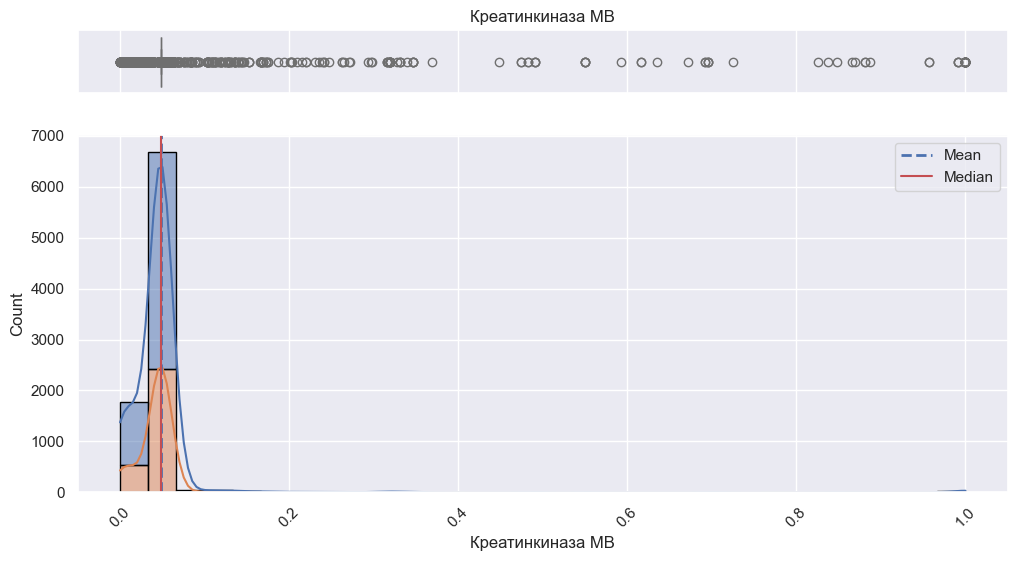

In [431]:
visualize_numerical_feature(df=train_df, 
                            feature='CK-MB', 
                            bins = 30, 
                            title='Креатинкиназа МВ', 
                            xlabel='Креатинкиназа МВ',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "CK-MB"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "Troponin"

Статистики для Troponin:
Уникальных значений: 340
Среднее: 0.04
Медиана: 0.04
Стандартное отклонение: 0.06
Минимум: 0.00
Максимум: 1.00
Q1: 0.04
Q3: 0.04
Количество выбросов: 2132


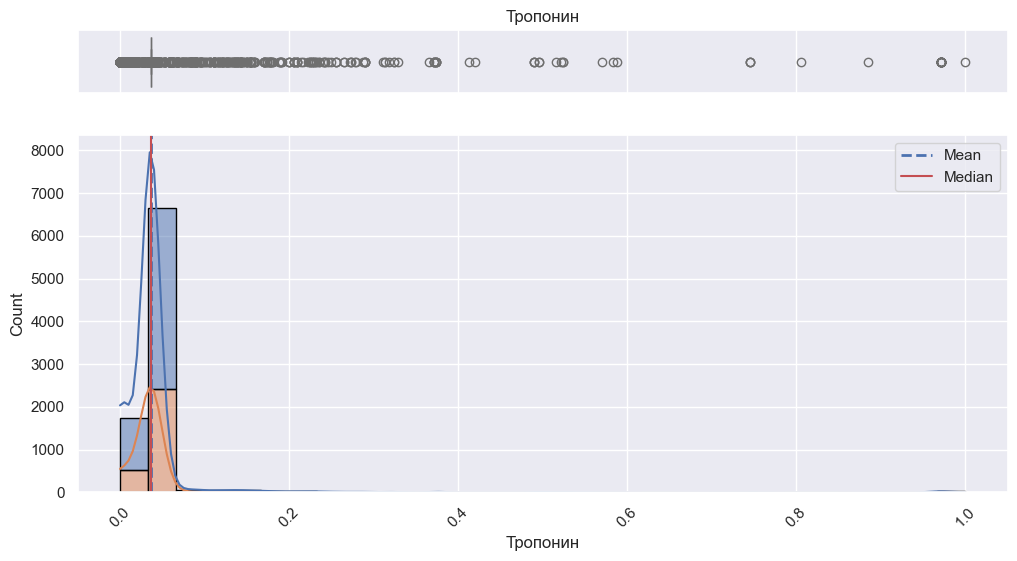

In [432]:
visualize_numerical_feature(df=train_df, 
                            feature='Troponin', 
                            bins = 30, 
                            title='Тропонин', 
                            xlabel='Тропонин',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Troponin"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "Systolic blood pressure"

Статистики для Systolic blood pressure:
Уникальных значений: 100
Среднее: 0.45
Медиана: 0.45
Стандартное отклонение: 0.17
Минимум: 0.00
Максимум: 1.00
Q1: 0.30
Q3: 0.60
Количество выбросов: 0


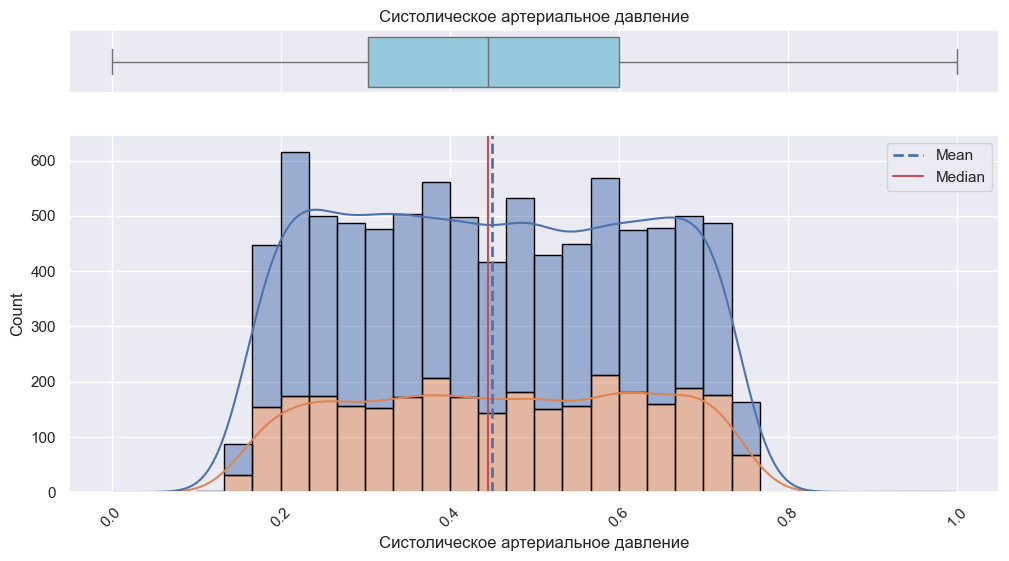

In [433]:
visualize_numerical_feature(df=train_df, 
                            feature='Systolic blood pressure', 
                            bins = 30, 
                            title='Систолическое артериальное давление', 
                            xlabel='Систолическое артериальное давление',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Systolic blood pressure"**:
- Данные отмасштабированны;

#### Количественный признак "Diastolic blood pressure"

Статистики для Diastolic blood pressure:
Уникальных значений: 66
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.17
Минимум: 0.00
Максимум: 1.00
Q1: 0.35
Q3: 0.65
Количество выбросов: 0


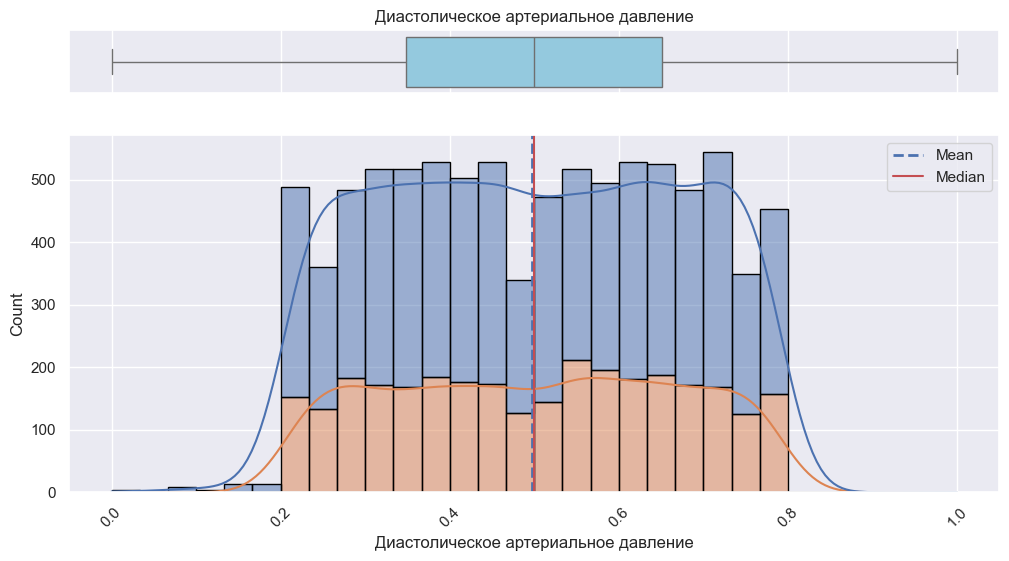

In [434]:
visualize_numerical_feature(df=train_df, 
                            feature='Diastolic blood pressure', 
                            bins = 30, 
                            title='Диастолическое артериальное давление', 
                            xlabel='Диастолическое артериальное давление',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Diastolic blood pressure"**:
- Данные отмасштабированны;

### Категориальный признак "Diabetes"

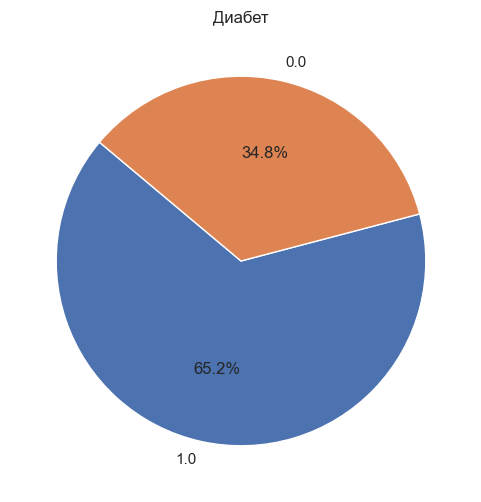

Статистика для Diabetes:
- Уникальные значения: 2

- Мода: 1.0

- Частота по категориям:
Diabetes
1.00    5505
0.00    2937
Name: count, dtype: int64

- Процентное соотношение:
Diabetes
1.00   65.00
0.00   35.00
Name: proportion, dtype: float64


In [435]:
visualize_categorical_feature(df=train_df, 
                              feature='Diabetes',
                             title='Диабет')

### Категориальный признак "Family History"

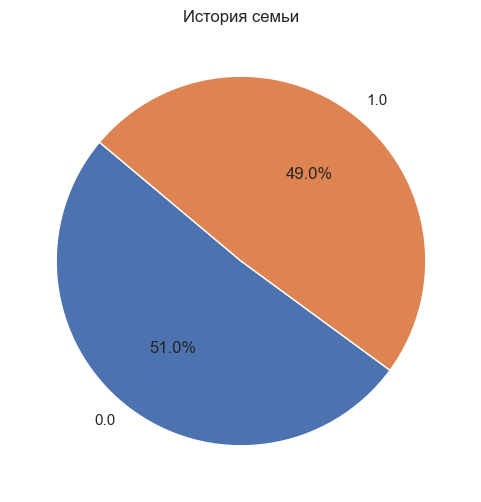

Статистика для Family History:
- Уникальные значения: 2

- Мода: 0.0

- Частота по категориям:
Family History
0.00    4309
1.00    4133
Name: count, dtype: int64

- Процентное соотношение:
Family History
0.00   51.00
1.00   49.00
Name: proportion, dtype: float64


In [436]:
visualize_categorical_feature(df=train_df, 
                              feature='Family History',
                             title='История семьи')

### Категориальный признак "Smoking"

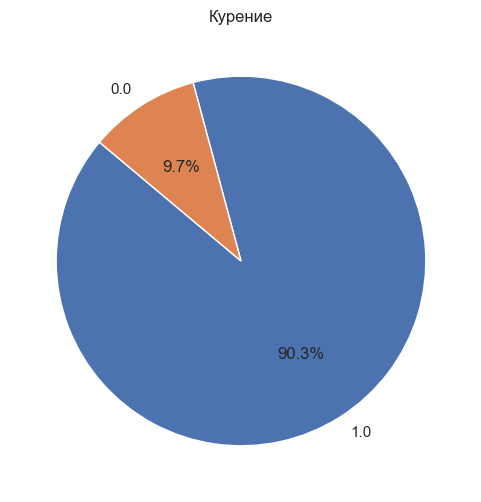

Статистика для Smoking:
- Уникальные значения: 2

- Мода: 1.0

- Частота по категориям:
Smoking
1.00    7622
0.00     820
Name: count, dtype: int64

- Процентное соотношение:
Smoking
1.00   90.00
0.00   10.00
Name: proportion, dtype: float64


In [437]:
visualize_categorical_feature(df=train_df, 
                              feature='Smoking',
                             title='Курение')

### Категориальный признак "Obesity"

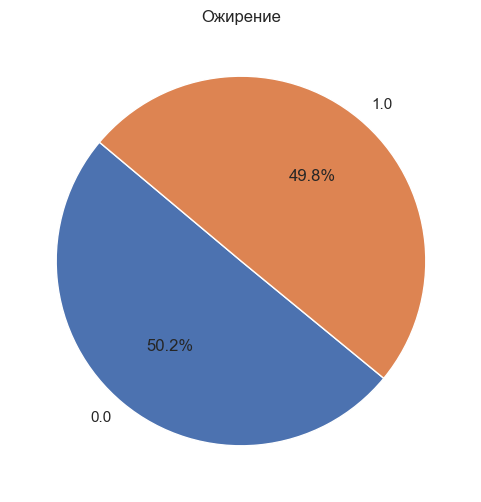

Статистика для Obesity:
- Уникальные значения: 2

- Мода: 0.0

- Частота по категориям:
Obesity
0.00    4235
1.00    4207
Name: count, dtype: int64

- Процентное соотношение:
Obesity
0.00   50.00
1.00   50.00
Name: proportion, dtype: float64


In [438]:
visualize_categorical_feature(df=train_df, 
                              feature='Obesity',
                             title='Ожирение')

### Категориальный признак "Alcohol Consumption"

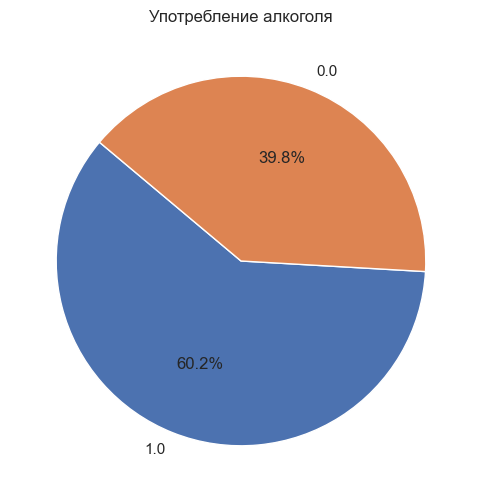

Статистика для Alcohol Consumption:
- Уникальные значения: 2

- Мода: 1.0

- Частота по категориям:
Alcohol Consumption
1.00    5082
0.00    3360
Name: count, dtype: int64

- Процентное соотношение:
Alcohol Consumption
1.00   60.00
0.00   40.00
Name: proportion, dtype: float64


In [439]:
visualize_categorical_feature(df=train_df, 
                              feature='Alcohol Consumption',
                             title='Употребление алкоголя')

### Категориальный признак "Diet"

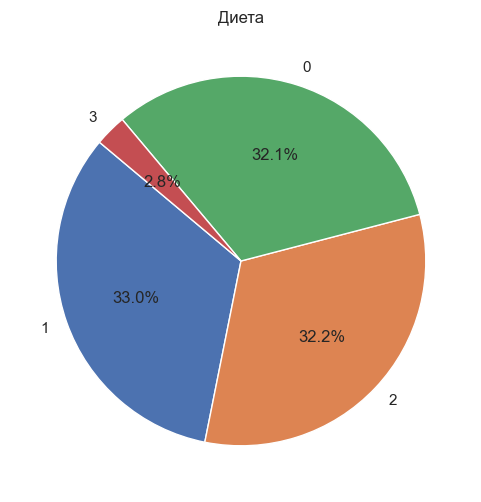

Статистика для Diet:
- Уникальные значения: 4

- Мода: 1

- Частота по категориям:
Diet
1    2863
2    2796
0    2783
3     241
Name: count, dtype: int64

- Процентное соотношение:
Diet
1   33.00
2   32.00
0   32.00
3    3.00
Name: proportion, dtype: float64


In [440]:
visualize_categorical_feature(df=train_df, 
                              feature='Diet',
                             title='Диета')

### Категориальный признак "Previous Heart Problems"

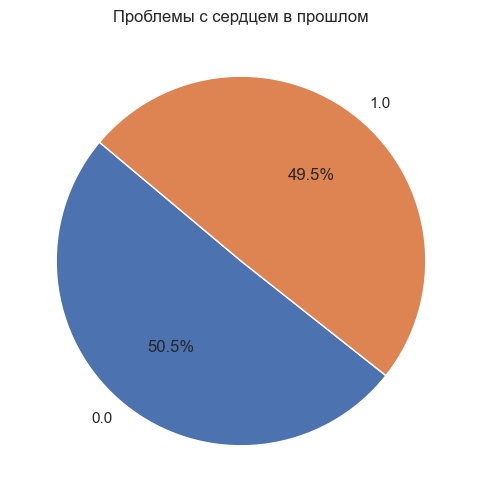

Статистика для Previous Heart Problems:
- Уникальные значения: 2

- Мода: 0.0

- Частота по категориям:
Previous Heart Problems
0.00    4260
1.00    4182
Name: count, dtype: int64

- Процентное соотношение:
Previous Heart Problems
0.00   50.00
1.00   50.00
Name: proportion, dtype: float64


In [441]:
visualize_categorical_feature(df=train_df, 
                              feature='Previous Heart Problems',
                             title='Проблемы с сердцем в прошлом')

### Категориальный признак "Medication Use"

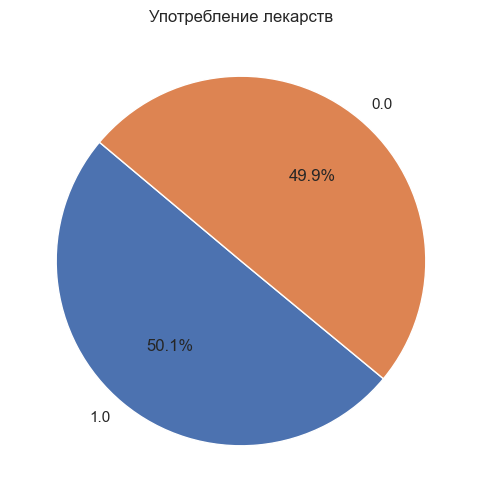

Статистика для Medication Use:
- Уникальные значения: 2

- Мода: 1.0

- Частота по категориям:
Medication Use
1.00    4231
0.00    4211
Name: count, dtype: int64

- Процентное соотношение:
Medication Use
1.00   50.00
0.00   50.00
Name: proportion, dtype: float64


In [442]:
visualize_categorical_feature(df=train_df, 
                              feature='Medication Use',
                             title='Употребление лекарств')

### Категориальный признак "Gender"

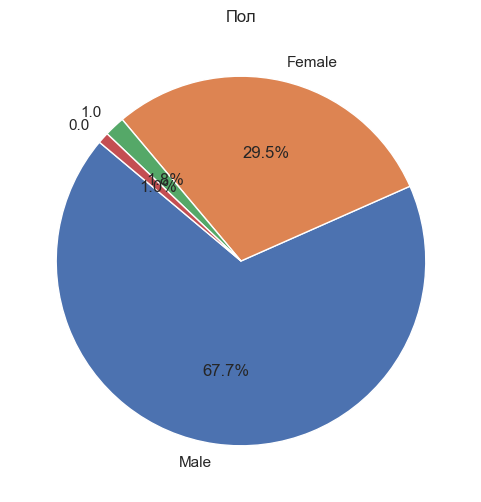

Статистика для Gender:
- Уникальные значения: 4

- Мода: Male

- Частота по категориям:
Gender
Male      5882
Female    2560
1.0        156
0.0         85
Name: count, dtype: int64

- Процентное соотношение:
Gender
Male     68.00
Female   29.00
1.0       2.00
0.0       1.00
Name: proportion, dtype: float64


In [443]:
visualize_categorical_feature(df=train_df, 
                              feature='Gender',
                             title='Пол')

### Категориальный признак "Heart Attack Risk (Binary)"

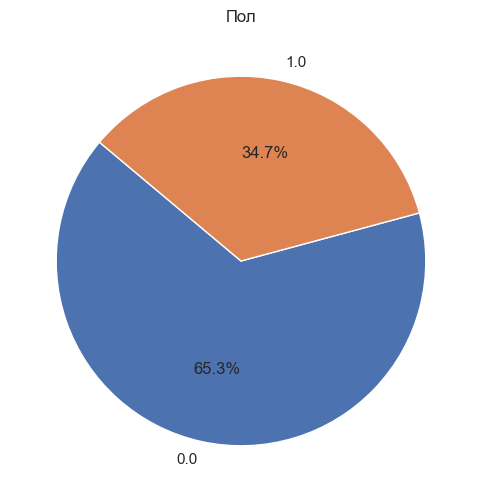

Статистика для Heart Attack Risk (Binary):
- Уникальные значения: 2

- Мода: 0.0

- Частота по категориям:
Heart Attack Risk (Binary)
0.00    5670
1.00    3013
Name: count, dtype: int64

- Процентное соотношение:
Heart Attack Risk (Binary)
0.00   65.00
1.00   35.00
Name: proportion, dtype: float64


In [444]:
visualize_categorical_feature(df=train_df, 
                              feature='Heart Attack Risk (Binary)',
                             title='Пол')

### Корреляционный анализ

In [445]:
train_df.sort_values('id').head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
7250,0.60,0.10,0.05,1.00,1.00,1.00,1.00,1.00,0.75,1,...,2.00,0.67,0.00,0.23,0.05,0.04,Male,0.57,0.57,1
4034,0.60,0.19,0.05,0.00,0.00,1.00,0.00,1.00,0.20,2,...,4.00,1.00,0.00,0.23,0.05,0.04,Male,0.19,0.67,2
8326,0.08,0.79,0.07,1.00,0.00,1.00,1.00,0.00,0.60,2,...,1.00,0.17,0.00,0.23,0.05,0.04,Male,0.25,0.38,4
7880,0.08,0.77,0.07,1.00,1.00,1.00,0.00,1.00,0.66,2,...,2.00,0.67,0.00,0.23,0.05,0.04,Male,0.74,0.38,5
5314,0.08,0.49,0.07,1.00,0.00,1.00,0.00,0.00,0.85,1,...,0.00,1.00,1.00,0.23,0.05,0.04,Male,0.42,0.72,6


In [446]:
# посчитаем корреляции 
train_phik_overview = train_df.drop(['id'], axis=1).phik_matrix(interval_cols=numerical_features)
print(train_phik_overview.shape)

(26, 26)


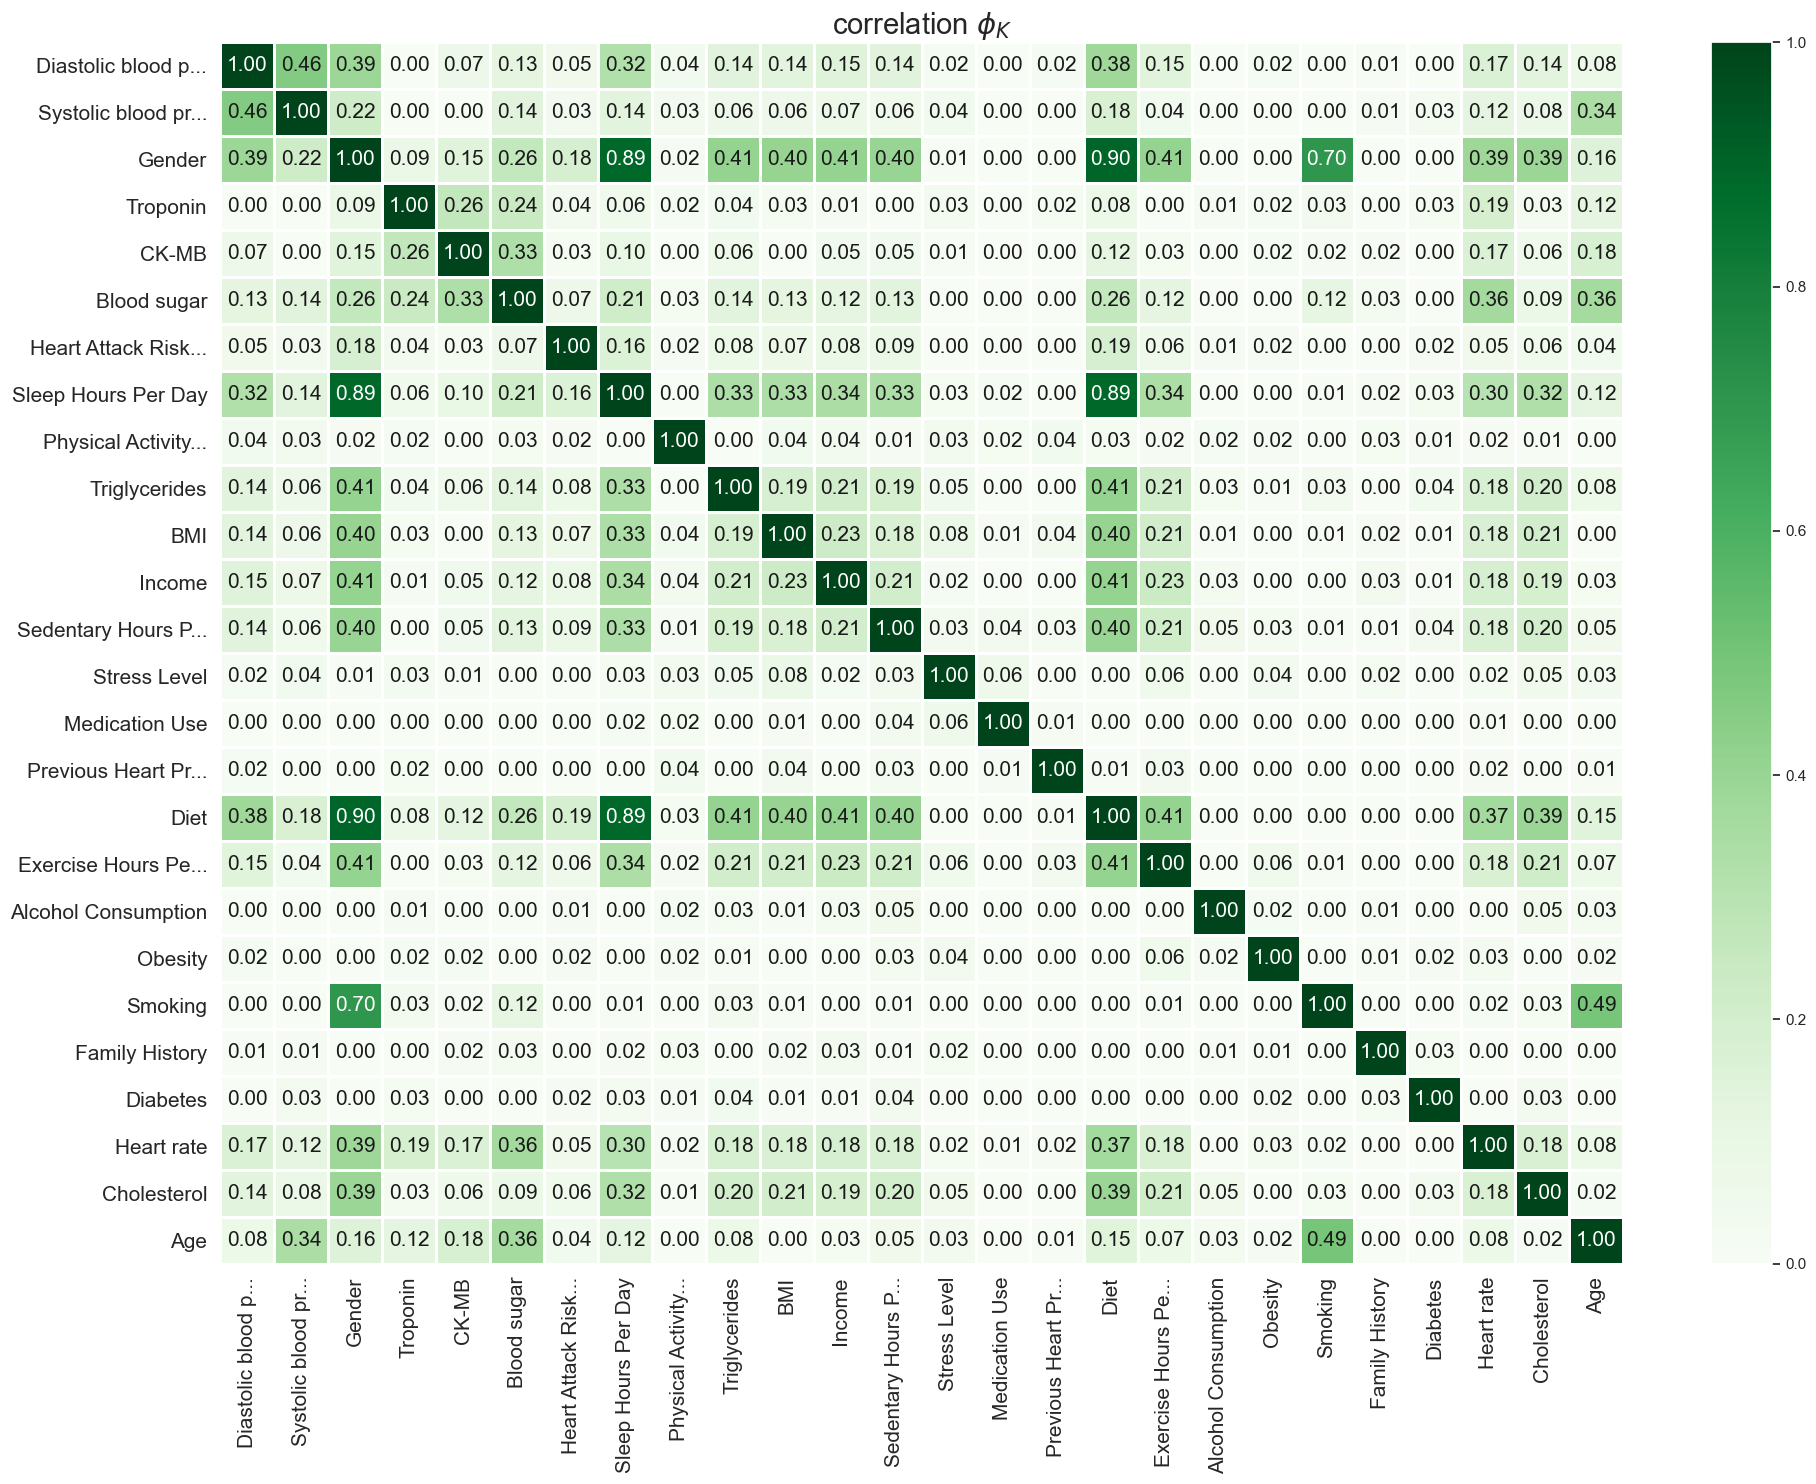

In [447]:
plot_correlation_matrix(
    train_phik_overview.values,
    x_labels=train_phik_overview.columns,
    y_labels=train_phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Вывод по разделу **"Иследование данных"**:
- Данные имеют плохое качество;
- Высокая кореляция между Diet и Sleep Hours Per Day

## Обучение моделей

При обучении модели, мы будем использовать метрику ROC-AUC по причине:
- несбалансированный целевой признак
- выбросы в данных

In [524]:
def trans_func(input):
    """
    Преобразует входные данные и заменяет значения.

    Функция заменяет 1.0 и 0.0 на Male и Female соответственно

    Параметры:
    - input: Массив или список данных, которые необходимо обработать.

    Возвращает:
    - Обработанный массив NumPy с замененными значениями.
    """
    # исправим 1 на Male и 0 на Female с учетом распределение по обеим видам категорий
    train_df['Gender'].replace('1.0', 'Male', inplace=True)
    train_df['Gender'].replace('0.0', 'Female', inplace=True)
    
    if not isinstance(input, np.ndarray):
        input = np.array(input)

    # заменяем ' ' на Nan
    output = np.where(input == '1.0', 'Male', input)
    output = np.where(input == '0.0', 'Female', output)

    return output

transformer = FunctionTransformer(trans_func)

In [525]:
# Выполним разделение датафреймов
X_train = train_df.drop(['id', 'Heart Attack Risk (Binary)'], axis=1)
y_train = train_df['Heart Attack Risk (Binary)']

X_test = test_df.drop(['id'], axis=1)

In [507]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8683 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8683 non-null   float64
 1   Cholesterol                      8683 non-null   float64
 2   Heart rate                       8683 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8683 non-null   float64
 9   Diet                             8683 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level             

In [546]:
ohe_columns = [
    'Gender'
]

ord_columns = ['Stress Level',
    'Physical Activity Days Per Week',
    'Sleep Hours Per Day'
]

num_columns = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use'
]

In [547]:
# Пайплайн для подготовки признаков из списка ohe_columns:
# - заполнение пропусков
# - OHE- кодирование

ohe_pipe = Pipeline(
    [
        ("trans", transformer),
        ('SimpeImputer_ohe', SimpleImputer(missing_values=np.nan, 
                                           strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [561]:
# Пайплайн для подготовки признаков из списка ord_columns
# - заполнение пропусков
# - Ordinal-кодирование

ord_pipe = Pipeline(
    [
        ("trans", transformer),
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan,
                                                  strategy='median')),
        ('ord', OrdinalEncoder(categories=[sorted(train_df['Stress Level'].unique().tolist()), 
                                           sorted(train_df['Physical Activity Days Per Week'].unique().tolist()),
                                           sorted(train_df['Sleep Hours Per Day'].unique().tolist())
                                          ],
                               handle_unknown='use_encoded_value',
                               unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='median'))
    ]
)

In [562]:
# Пайплайн для подготовки количественных признаков
num_pipe = Pipeline(
    [
        ('SimpeImputer_num', SimpleImputer(missing_values=np.nan, 
                                           strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [563]:
# Пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

In [564]:
# Итоговый пайплайн
final_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [603]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': distributions.CategoricalDistribution([DecisionTreeClassifier(random_state=RANDOM_STATE)]),
        'models__max_depth': distributions.IntDistribution(5, 12),
        'models__max_features': distributions.IntDistribution(5, 12),
        'preprocessor__num__scaler': distributions.CategoricalDistribution(['passthrough'])
    },
    
    # LGBMClassifier
    {
        'models': distributions.CategoricalDistribution([lgb.LGBMClassifier(random_state=RANDOM_STATE)]),
        'models__learning_rate': distributions.CategoricalDistribution([0.001, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5]),
        'models__num_leaves': distributions.CategoricalDistribution([1, 2, 4, 6, 8, 10, 15, 20, 30, 50]),
        'models__n_estimators': distributions.CategoricalDistribution([25, 50, 100, 125, 150]),
        'models__max_depth': distributions.IntDistribution(2, 10),
        'preprocessor__num__scaler': distributions.CategoricalDistribution(['passthrough'])
    },
    

    # словарь для модели LogisticRegression()
    {
        'models': distributions.CategoricalDistribution([LogisticRegression(random_state=RANDOM_STATE, 
                                                              penalty='elasticnet', 
                                                              solver='saga')]),
        'models__l1_ratio': distributions.CategoricalDistribution([0, 0.1, 0.2, 0.3, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'models__C': distributions.IntDistribution(1, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': distributions.CategoricalDistribution([KNeighborsClassifier()]),
        'models__n_neighbors': distributions.IntDistribution(2, 6),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough'])
    }
]

optuna_tree = OptunaSearchCV(
        final_pipe,
        param_grid[0],
        cv=5,
        scoring='roc_auc',
        n_trials=15,
        random_state=RANDOM_STATE
    )

optuna_lgbm= OptunaSearchCV(
        final_pipe,
        param_grid[1],
        cv=5,
        scoring='roc_auc',
        n_trials=100,
        random_state=RANDOM_STATE
    )

optuna_logistic = OptunaSearchCV(
        final_pipe,
        param_grid[2],
        cv=5,
        scoring='roc_auc',
        n_trials=1,
        random_state=RANDOM_STATE
    )

optuna_knn = OptunaSearchCV(
        final_pipe,
        param_grid[3],
        cv=5,
        scoring='roc_auc',
        n_trials=10,
        random_state=RANDOM_STATE
    )

In [604]:
optuna_tree.fit(X_train, y_train)
print()

[I 2025-08-23 20:53:16,229] A new study created in memory with name: no-name-0e0aed34-db31-4dd3-b2a4-a3b9adf295e0
[I 2025-08-23 20:53:16,820] Trial 0 finished with value: 0.5272962131574661 and parameters: {'models': DecisionTreeClassifier(max_depth=8, max_features=11, random_state=42), 'models__max_depth': 8, 'models__max_features': 11, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 0 with value: 0.5272962131574661.
[I 2025-08-23 20:53:17,205] Trial 1 finished with value: 0.527372612990757 and parameters: {'models': DecisionTreeClassifier(max_depth=5, max_features=7, random_state=42), 'models__max_depth': 5, 'models__max_features': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.527372612990757.
[I 2025-08-23 20:53:17,623] Trial 2 finished with value: 0.5332934772719515 and parameters: {'models': DecisionTreeClassifier(max_depth=8, max_features=7, random_state=42), 'models__max_depth': 8, 'models__max_features': 7, 'preprocessor__num__scaler':

In [605]:
optuna_lgbm.fit(X_train, y_train)
print()

[I 2025-08-23 20:53:23,410] A new study created in memory with name: no-name-423d6306-46bc-402d-aa43-d27b8b215cee


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-23 20:53:23,952] Trial 0 finished with value: 0.5379913322911051 and parameters: {'models': LGBMClassifier(learning_rate=0.05, max_depth=9, n_estimators=25, num_leaves=8,
               random_state=42), 'models__learning_rate': 0.05, 'models__num_leaves': 8, 'models__n_estimators': 25, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 0 with value: 0.5379913322911051.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warnin

[I 2025-08-23 20:53:24,748] Trial 1 finished with value: 0.5629844706168513 and parameters: {'models': LGBMClassifier(max_depth=6, n_estimators=125, num_leaves=20, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 20, 'models__n_estimators': 125, 'models__max_depth': 6, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5629844706168513.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:25,279] Trial 2 finished with value: 0.516300927719931 and parameters: {'models': LGBMClassifier(max_depth=2, n_estimators=25, num_leaves=15, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 15, 'models__n_estimators': 25, 'models__max_depth': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5629844706168513.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-23 20:53:25,810] Trial 3 finished with value: 0.5214286015513359 and parameters: {'models': LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=25, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.05, 'models__num_leaves': 20, 'models__n_estimators': 25, 'models__max_depth': 3, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5629844706168513.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:26,373] Trial 4 finished with value: 0.5345826273796244 and parameters: {'models': LGBMClassifier(max_depth=3, n_estimators=50, num_leaves=30, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 30, 'models__n_estimators': 50, 'models__max_depth': 3, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 1 with value: 0.5629844706168513.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:27,175] Trial 5 finished with value: 0.5647651443194768 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=9, n_estimators=150, num_leaves=10,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 10, 'models__n_estimators': 150, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 5 with value: 0.5647651443194768.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-23 20:53:28,081] Trial 6 finished with value: 0.5731646347744521 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=10, n_estimators=150, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 20, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-23 20:53:28,708] Trial 7 finished with value: 0.5263329376756796 and parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=10, n_estimators=50,
               num_leaves=15, random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 15, 'models__n_estimators': 50, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGB

[W 2025-08-23 20:53:29,040] Trial 8 failed with parameters: {'models': LGBMClassifier(max_depth=10, n_estimators=25, num_leaves=1, random_state=42), 'models__learning_rate': 0.1, 'models__num_leaves': 1, 'models__n_estimators': 25, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:29,041] Trial 8 failed with value nan.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:29,566] Trial 9 finished with value: 0.5284971808153244 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=2, n_estimators=25, num_leaves=20,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 20, 'models__n_estimators': 25, 'models__max_depth': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing

[I 2025-08-23 20:53:30,135] Trial 10 finished with value: 0.5178941299681269 and parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=9, num_leaves=2, random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 2, 'models__n_estimators': 100, 'models__max_depth': 9, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] 

[I 2025-08-23 20:53:30,889] Trial 11 finished with value: 0.5485493576218431 and parameters: {'models': LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=150, num_leaves=6,
               random_state=42), 'models__learning_rate': 0.3, 'models__num_leaves': 6, 'models__n_estimators': 150, 'models__max_depth': 6, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-23 20:53:31,702] Trial 12 finished with value: 0.5644410612693047 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=8, n_estimators=150, num_leaves=10,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 10, 'models__n_estimators': 150, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.
[W 2025-08-23 20:53:32,068] Trial 13 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:32,069] Trial 13 failed with value nan.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-23 20:53:32,879] Trial 14 finished with value: 0.5581347560528804 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=8, n_estimators=150, num_leaves=10,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 10, 'models__n_estimators': 150, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 6 with value: 0.5731646347744521.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004


[W 2025-08-23 20:53:33,267] Trial 15 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:33,267] Trial 15 failed with value nan.
[W 2025-08-23 20:53:33,615] Trial 16 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:33,616] Trial 16 failed with value nan.


[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:34,859] Trial 17 finished with value: 0.5867753328878857 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:36,090] Trial 18 finished with value: 0.5867753328878857 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-23 20:53:37,016] Trial 19 finished with value: 0.5645651855215885 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=7, num_leaves=50, random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 50, 'models__n_estimators': 100, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:37,853] Trial 20 finished with value: 0.5809739415640329 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=5, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-08-23 20:53:38,191] Trial 21 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:38,191] Trial 21 failed with value nan.
[W 2025-08-23 20:53:38,510] Trial 22 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:38,510] Trial 22 failed with value nan.
[W 2025-08-23 20:53:38,827] Trial 23 failed with parameters: {'models': LG

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGB

[I 2025-08-23 20:53:41,415] Trial 30 finished with value: 0.5483242040465154 and parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=10, n_estimators=150, num_leaves=4,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 4, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Info] 

[I 2025-08-23 20:53:42,691] Trial 31 finished with value: 0.5450728662872539 and parameters: {'models': LGBMClassifier(learning_rate=0.001, max_depth=8, n_estimators=150,
               num_leaves=50, random_state=42), 'models__learning_rate': 0.001, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 8, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004


[W 2025-08-23 20:53:43,028] Trial 32 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:43,028] Trial 32 failed with value nan.
[W 2025-08-23 20:53:43,345] Trial 33 failed with parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=5, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:43,345] Trial 33 failed with value nan.
[W 2025-08-23 20:53:43,663] Trial 34 failed with parameters: {'models': LGBM

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:49,875] Trial 51 finished with value: 0.5849078385759139 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-08-23 20:53:50,213] Trial 52 failed with parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=5, num_leaves=1, random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 1, 'models__n_estimators': 100, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:50,214] Trial 52 failed with value nan.
[W 2025-08-23 20:53:50,536] Trial 53 failed with parameters: {'models': LGBMClassifier(learning_rate=0.5, max_depth=5, n_estimators=125, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.5, 'models__num_leaves': 1, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:50,537] Trial 53 failed with value nan.
[W 2025-08-23 20:53:50,876] Trial 54 failed with parameters: {'models': LGBMClassifier(learning_rate=0.08, ma

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:54,036] Trial 63 finished with value: 0.5605554248130404 and parameters: {'models': LGBMClassifier(learning_rate=0.08, max_depth=5, n_estimators=125, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.08, 'models__num_leaves': 50, 'models__n_estimators': 125, 'models__max_depth': 5, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[W 2025-08-23 20:53:54,365] Trial 64 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:54,366] Trial 64 failed with value nan.
[W 2025-08-23 20:53:54,668] Trial 65 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:54,668] Trial 65 failed with value nan.
[W 2025-08-23 20:53:54,961] Trial 66 failed with parameters: {'models': LGBMCl

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:53:57,237] Trial 71 finished with value: 0.5849078385759139 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 7, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 17 with value: 0.5867753328878857.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[W 2025-08-23 20:53:57,593] Trial 72 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:57,593] Trial 72 failed with value nan.
[W 2025-08-23 20:53:57,933] Trial 73 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:53:57,934] Trial 73 failed with value nan.
[W 2025-08-23 20:53:58,265] Trial 74 failed with parameters: {'models': LG

[LightGBM] [Info] Number of positive: 2410, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2508
[LightGBM] [Info] Number of data points in the train set: 6946, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346962 -> initscore=-0.632419
[LightGBM] [Info] Start training from score -0.632419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-23 20:54:06,610] Trial 97 finished with value: 0.5890489806937469 and parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=50,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 50, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 97 with value: 0.5890489806937469.


[LightGBM] [Info] Number of positive: 2411, number of negative: 4536
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 6947, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347056 -> initscore=-0.632004
[LightGBM] [Info] Start training from score -0.632004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[W 2025-08-23 20:54:06,952] Trial 98 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:54:06,953] Trial 98 failed with value nan.
[W 2025-08-23 20:54:07,273] Trial 99 failed with parameters: {'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
               random_state=42), 'models__learning_rate': 0.2, 'models__num_leaves': 1, 'models__n_estimators': 150, 'models__max_depth': 10, 'preprocessor__num__scaler': 'passthrough'} because of the following error: The value nan is not acceptable.
[W 2025-08-23 20:54:07,274] Trial 99 failed with value nan.


[LightGBM] [Info] Number of positive: 3013, number of negative: 5670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 8683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347000 -> initscore=-0.632253
[LightGBM] [Info] Start training from score -0.632253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [606]:
optuna_logistic.fit(X_train, y_train)
print()

[I 2025-08-23 20:54:07,511] A new study created in memory with name: no-name-85afbe9f-647e-4f2b-a10b-c217db78179d
[I 2025-08-23 20:54:08,289] Trial 0 finished with value: 0.5284718315372536 and parameters: {'models': LogisticRegression(C=6, l1_ratio=0.1, penalty='elasticnet', random_state=42,
                   solver='saga'), 'models__l1_ratio': 0.1, 'models__C': 6, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5284718315372536.


In [607]:
optuna_knn.fit(X_train, y_train)
print()

[I 2025-08-23 20:54:08,459] A new study created in memory with name: no-name-5bc0324d-1ecd-43c8-91b3-06e12f33d049
[I 2025-08-23 20:54:09,012] Trial 0 finished with value: 0.5438020298487252 and parameters: {'models': KNeighborsClassifier(n_neighbors=4), 'models__n_neighbors': 4, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5438020298487252.
[I 2025-08-23 20:54:09,596] Trial 1 finished with value: 0.5438020298487252 and parameters: {'models': KNeighborsClassifier(n_neighbors=4), 'models__n_neighbors': 4, 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.5438020298487252.
[I 2025-08-23 20:54:10,142] Trial 2 finished with value: 0.5488274760054933 and parameters: {'models': KNeighborsClassifier(n_neighbors=2), 'models__n_neighbors': 2, 'preprocessor__num__scaler': 'passthrough'}. Best is trial 2 with value: 0.5488274760054933.
[I 2025-08-23 20:54:10,716] Trial 3 finished with value: 0.5546051043549248 and parameters: {'models': 

In [608]:
# Результаты по кросс-валидации для модели DecisionTreeClassifier
tree_model = pd.DataFrame(optuna_tree.cv_results_)
max_tree_model = tree_model["mean_test_score"].max()
print(f'Модель = DecisionTreeRegressor. ROC-AUC кросс-валидации: {round(max_tree_model, 2)}')

# Результаты по кросс-валидации для модели LGBMClassifier
lgbm_model = pd.DataFrame(optuna_lgbm.cv_results_)
max_lgbm_model = lgbm_model["mean_test_score"].max()
print(f'Модель = LGBMClassifier. ROC-AUC кросс-валидации: {round(max_lgbm_model, 2)}')

# Результаты по кросс-валидации для модели LogisticRegression
logistic_model = pd.DataFrame(optuna_logistic.cv_results_)
max_logistic_model = logistic_model["mean_test_score"].max()
print(f'Модель = LogisticRegression. ROC-AUC кросс-валидации: {round(max_logistic_model, 2)}')

# Результаты по кросс-валидации для модели KNeighborsClassifier
knn_model = pd.DataFrame(optuna_knn.cv_results_)
max_knn_model = knn_model["mean_test_score"].max()
print(f'Модель = KNeighborsClassifier. ROC-AUC кросс-валидации: {round(max_knn_model, 2)}')

Модель = DecisionTreeRegressor. ROC-AUC кросс-валидации: 0.55
Модель = LGBMClassifier. ROC-AUC кросс-валидации: 0.59
Модель = LogisticRegression. ROC-AUC кросс-валидации: 0.53
Модель = KNeighborsClassifier. ROC-AUC кросс-валидации: 0.55


Лучшей моделью стала LGBMClassifier с ROC-AUC кросс-валидации: 0.59. 

Параметры лучшей модели

In [611]:
optuna_lgbm.best_params_['models']

,boosting_type,'gbdt'
,num_leaves,1
,max_depth,10
,learning_rate,0.2
,n_estimators,150
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


#### Предсказание на тестовом датасете

In [619]:
predictions = pd.concat(
    [
    test_df['id'],
    pd.Series(optuna_lgbm.predict(X_test))
    ], 
    axis=1
)
predictions                

,id,0
0,7746,0.00
1,4202,1.00
2,6632,0.00
3,4639,0.00
4,4825,0.00
...,...,...
961,9271,0.00
962,8012,1.00
963,2456,0.00
964,4984,0.00


In [621]:
# сохраним предсказание в csv
try:
    predictions.to_csv('predictions.csv', 
                       index=False,
                       encoding='utf-8',
                       sep=',')
except Exception as e:
    print("Ошибка при сохранении")

### Важность признаков

In [647]:
model = optuna_lgbm.best_estimator_.named_steps['models']
feature_importance = pd.concat([pd.Series(X_train.columns), pd.Series(model.feature_importances_)], axis=1)
feature_importance.columns = ['Feature', 'Importance']
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance

,Feature,Importance
7,Alcohol Consumption,644
11,Medication Use,614
10,Previous Heart Problems,612
5,Smoking,606
9,Diet,589
8,Exercise Hours Per Week,574
4,Family History,543
15,BMI,532
6,Obesity,529
16,Triglycerides,500


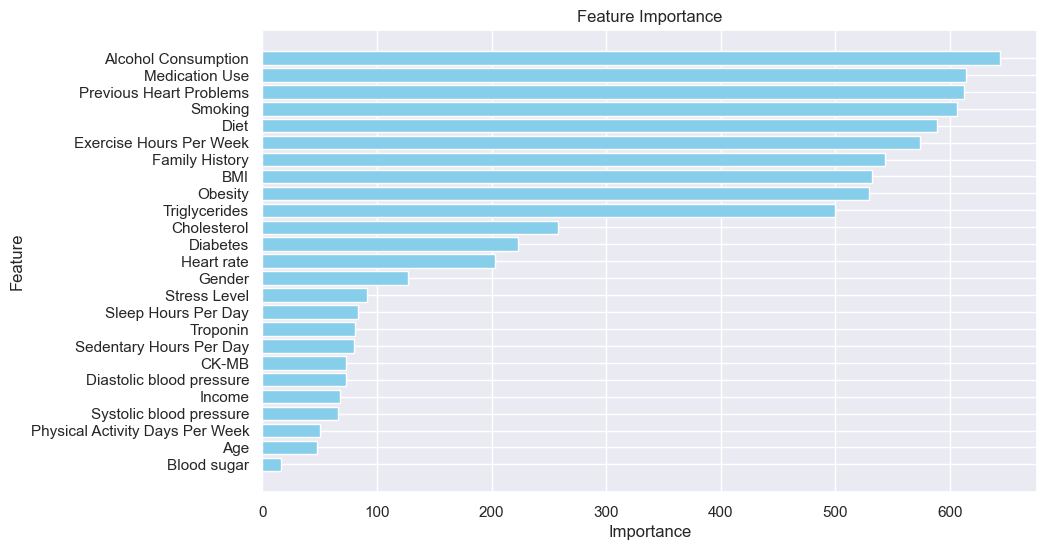

In [655]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Инвертируем ось Y для лучшего отображения
plt.show()

## Выводы

In [657]:
optuna_lgbm.best_params_

{'models': LGBMClassifier(learning_rate=0.2, max_depth=10, n_estimators=150, num_leaves=1,
                random_state=42),
 'models__learning_rate': 0.2,
 'models__num_leaves': 50,
 'models__n_estimators': 150,
 'models__max_depth': 10,
 'preprocessor__num__scaler': 'passthrough'}

- Выполнена загрузка данных;
- Выполнена предобработка данных:
    - Выявлены пропуски в данных;
    - Выявлены аномалии в данных в признаке **Gender**
    - Удалены выбросы в признаке **Heart rate**;
    - Дубликаты отсутствуют;
- Выполнен исследовательский анализ данных:
    - Признаки масштабированы;
    - Обнаружены выбросы;
    - Выполнен корреляционный анализ - мультиколениарность не обнаружена
- Выполнено обучение моделей:
    - Выбрана метрика ROC-AUC;
    - Обучены модели LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, LGBMClassifier
    - Лучшая модель - LGBMClassifier с ROC-AUC = 0.59
    - Параметры лучшей модели LGBMClassifier:
        - *learning_rate=0.2,*
        - *max_depth=10,*
        - *n_estimators=150,*
        - *num_leaves=1,*
        - *random_state=42*
    - Выполнено предсказание для тестовых данных и сохранены в файл **predictions.csv**
    - Признаки, оказывающие наибольшее влияние:
        - *Alcohol Consumption = 644,*
        - *Medication Use = 614,*
        - Previous Heart Problems = 612,
        - Smoking = 606,
        - Diet = 589,
        - Exercise Hours Per Week = 574,
        - Family History = 543,
        - BMI = 532,
        - Obesity = 529,
        - Triglycerides = 500